Polynomial regression to model the trend of the variable "Funkcja_stand_min_max" (c(x)) over time. It loads and preprocesses the data, a time index is created as an independent variable. At the moment, the polynomial is fitted to the entire dataset, due to reasons brought up in the report. Polynomial regression with degrees ranging from 1 to 10 are fitted and evaluated using 2-fold cross-validation. The best polynomial degree is selected based on the lowest cross-validation MSE. The Polynomial is then used to generate predictions for the entire dataset with performance evaluated using MSE and MAPE.

Degree 1 => Cross-Validation MSE: 0.01016806261584561
Degree 2 => Cross-Validation MSE: 0.003575272990903827
Degree 3 => Cross-Validation MSE: 0.003571938934168137
Degree 4 => Cross-Validation MSE: 0.0024317583286705157
Degree 5 => Cross-Validation MSE: 0.0018825136955013839
Degree 6 => Cross-Validation MSE: 0.0018544064527611201
Degree 7 => Cross-Validation MSE: 0.0020821850314953995
Degree 8 => Cross-Validation MSE: 0.00107106762776588
Degree 9 => Cross-Validation MSE: 0.0011216599829965972
Degree 10 => Cross-Validation MSE: 0.001755587117380125

Best polynomial degree: 8 with Cross-Validation MSE: 0.00107106762776588
Final MSE: 0.0007435988520348297
Final MAPE: 9.873326418371%


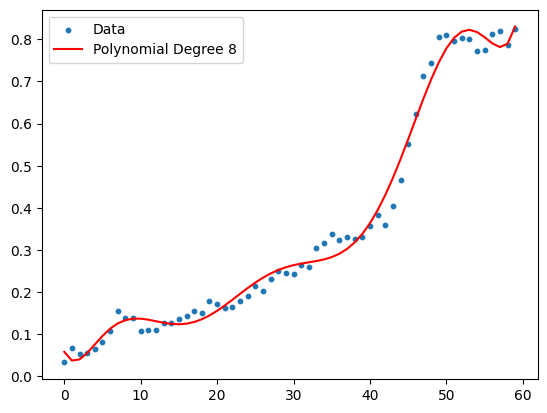

In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import statsmodels.api as sm
import statsmodels.stats.diagnostic as diag
from scipy.stats import shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score, KFold
import time
from statsmodels.stats.diagnostic import het_breuschpagan

df = pd.read_excel("DANE.xlsx", sheet_name="resorc")

# Column conversion
for col in df.columns[2:]:  
    df[col] = df[col].astype(str).str.replace(',', '.').astype(float)

# Time index
X_time = np.arange(len(df)).reshape(-1, 1)
y_values = df["Funkcja_stand_min_max"].values

# Cross-validation settings
kf = KFold(n_splits=2, shuffle=True, random_state=42) # 2-fold CV

# Range of polynomial degrees
degrees = range(1, 11)
mse_list = []

for d in degrees:
    poly = PolynomialFeatures(degree=d)
    X_poly = poly.fit_transform(X_time)

    model_poly = LinearRegression()
    
    # Cross-validation error
    mse_cv = -np.mean(cross_val_score(model_poly, X_poly, y_values, scoring='neg_mean_squared_error', cv=kf))
    mse_list.append(mse_cv)

    print(f"Degree {d} => Cross-Validation MSE: {mse_cv}")

best_degree = degrees[np.argmin(mse_list)]
best_poly = PolynomialFeatures(degree=best_degree)
X_time_poly = best_poly.fit_transform(X_time)

model_best = LinearRegression().fit(X_time_poly, y_values)
print(f"\nBest polynomial degree: {best_degree} with Cross-Validation MSE: {min(mse_list)}")

# Predictions
funkcja_poly_pred = model_best.predict(X_time_poly)

# Compute overall MSE & MAPE
mse_final = mean_squared_error(y_values, funkcja_poly_pred)
mape_final = mean_absolute_percentage_error(y_values, funkcja_poly_pred) * 100

print(f"Final MSE: {mse_final}")
print(f"Final MAPE: {mape_final}%")

# Visualization
plt.scatter(X_time, y_values, label="Data", s=10)
plt.plot(X_time, funkcja_poly_pred, label=f"Polynomial Degree {best_degree}", color='red')
plt.legend()
plt.show()

# For later use
df["Funkcja_poly_trend"] = funkcja_poly_pred


Adding the values from the polynomial for use in test.

In [2]:
train_size_ratio = 0.8  
split_index = int(len(df) * train_size_ratio)

# Overwrite df["Funkcja_stand_min_max"] with df["Funkcja_poly_trend"] in the test portion
df.loc[split_index:, "Funkcja_stand_min_max"] = df.loc[split_index:, "Funkcja_poly_trend"]

Multi-step forecasting approach using linear regression. Code first scales the input data using MinMaxScaler and prepares datasets for different forecast horizons (t+1 to t+4). For each horizon, it constructs input vectors that include past values of "cena_za_m" and future values of "Funkcja_stand_min_max" as exogenous variables. The data is split into training and test sets (80/20 ratio), and linear regression models are trained without an intercept (no constant). Model performance is evaluated using MSE, MAE, MAPE, and R² scores, with inverse scaling applied to predictions for interpretation. Statistical tests such as Shapiro-Wilk, Durbin-Watson, and Breusch-Pagan are conducted on residuals to assess assumptions. The trained models are used to make future predictions, and results are stored in dataframes for further analysis. Model parameters and training times are displayed, providing insights into the forecasting  and training process.

Training time for horizon t+1: 0.0000 seconds
Horizon t+1:
 - Input shape: (59, 2) (features per sample: 2)
 - Train size: 47, Test size: 12
Train Metrics (Original Scale): MSE: 14707.6640, MAE: 92.2061, MAPE: 1.13%, R²: 0.9855
Test Metrics  (Original Scale): MSE: 93381.4824, MAE: 242.8252, MAPE: 1.96%, R²: 0.9478
Statistical tests for Horizon t+1 (Test Data, Original Scale):
 - Shapiro–Wilk: stat = 0.9416, p-value = 0.5193
 - Durbin–Watson: 1.9489
 - Breusch–Pagan: LM stat = 1.4364, p-value = 0.4876

Variance Inflation Factor (VIF):
  Feature       VIF
0      X0  6.408022
1      X1  6.408022

Ramsey RESET Test:
 - F-statistic: 0.8092
 - p-value: 0.3734
 - df_diff: 1.0, df_resid: 43.0


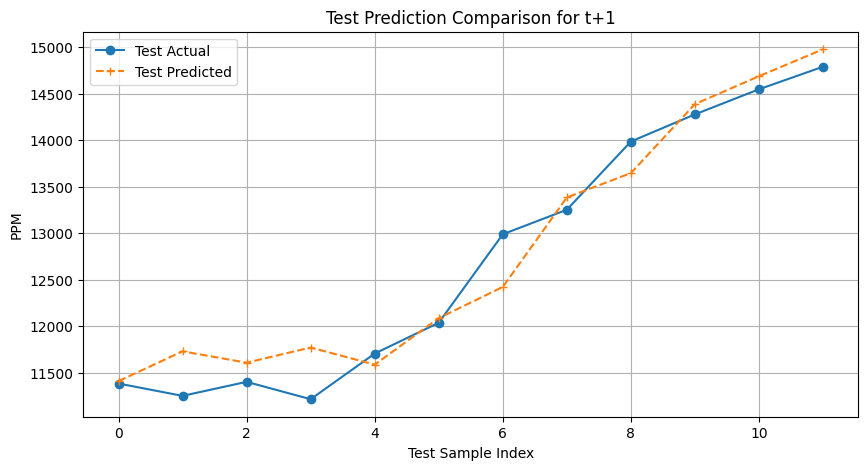

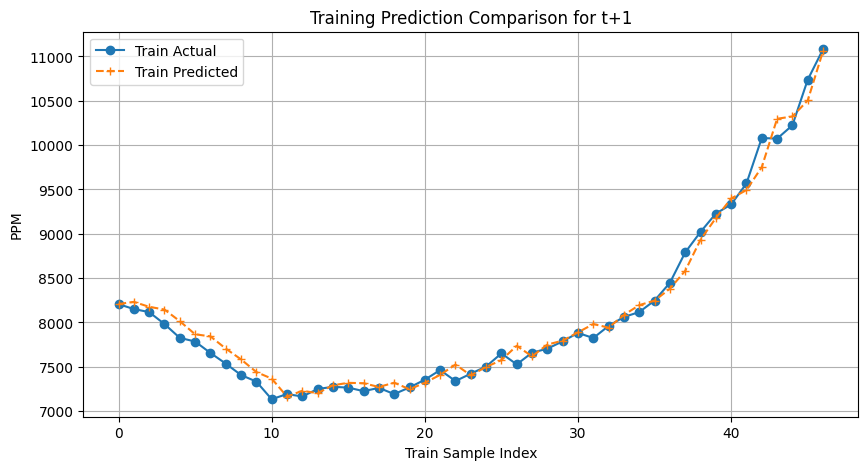

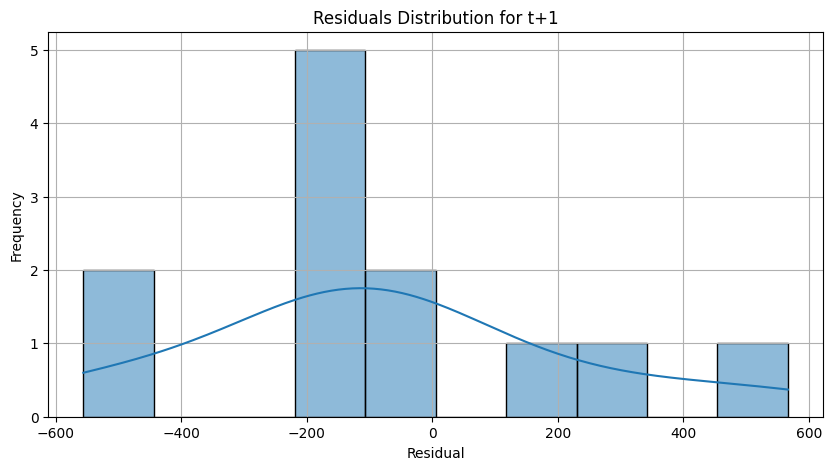

<Figure size 1000x500 with 0 Axes>

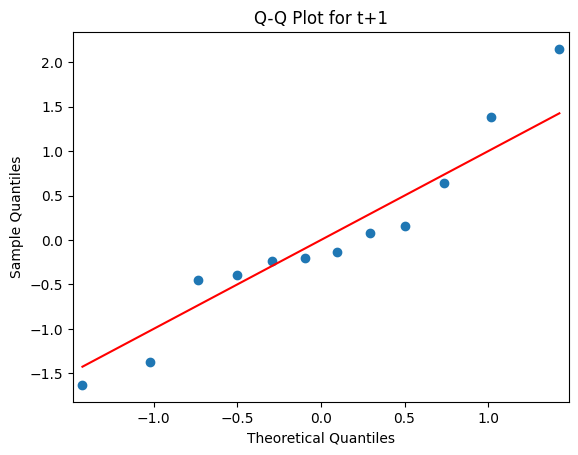

Training time for horizon t+2: 0.0000 seconds
Horizon t+2:
 - Input shape: (58, 3) (features per sample: 3)
 - Train size: 46, Test size: 12
Train Metrics (Original Scale): MSE: 35763.0136, MAE: 152.9407, MAPE: 1.89%, R²: 0.9654
Test Metrics  (Original Scale): MSE: 184209.7325, MAE: 368.8290, MAPE: 2.99%, R²: 0.8971
Statistical tests for Horizon t+2 (Test Data, Original Scale):
 - Shapiro–Wilk: stat = 0.9533, p-value = 0.6857
 - Durbin–Watson: 0.5162
 - Breusch–Pagan: LM stat = 4.7926, p-value = 0.1876

Variance Inflation Factor (VIF):
  Feature         VIF
0      X0    6.509919
1      X1  139.281748
2      X2  157.864021

Ramsey RESET Test:
 - F-statistic: 0.1008
 - p-value: 0.7525
 - df_diff: 1.0, df_resid: 41.0


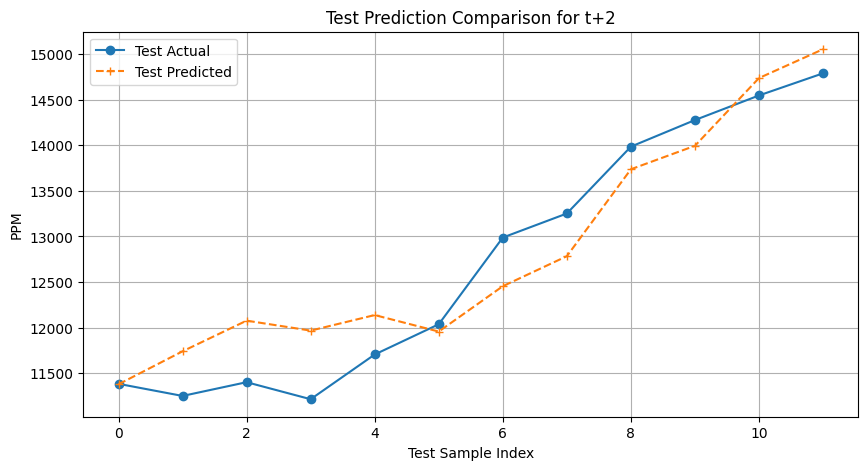

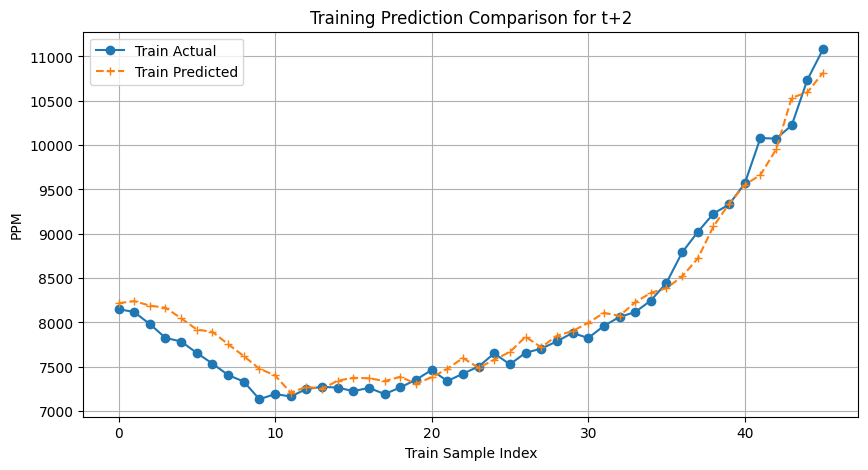

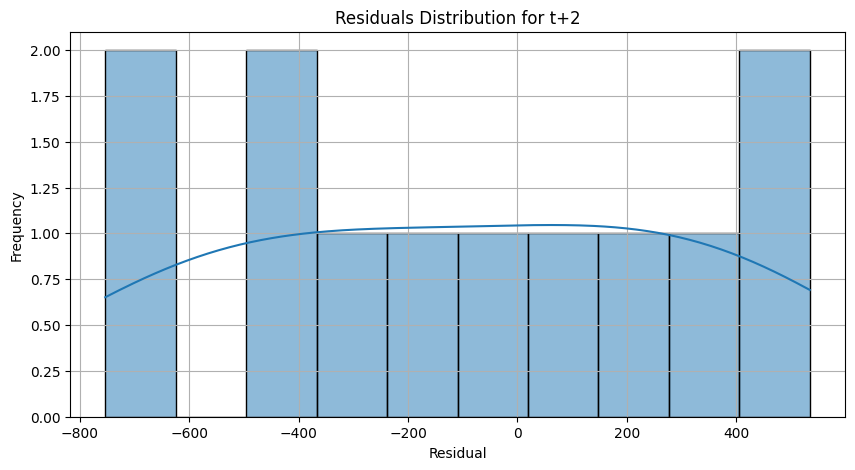

<Figure size 1000x500 with 0 Axes>

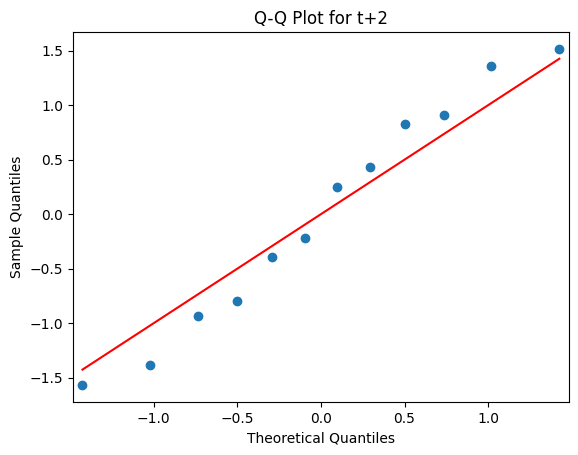

Training time for horizon t+3: 0.0010 seconds
Horizon t+3:
 - Input shape: (57, 4) (features per sample: 4)
 - Train size: 45, Test size: 12
Train Metrics (Original Scale): MSE: 59819.7024, MAE: 200.5643, MAPE: 2.53%, R²: 0.9434
Test Metrics  (Original Scale): MSE: 362690.4943, MAE: 541.3422, MAPE: 4.38%, R²: 0.7974
Statistical tests for Horizon t+3 (Test Data, Original Scale):
 - Shapiro–Wilk: stat = 0.9555, p-value = 0.7180
 - Durbin–Watson: 0.8202
 - Breusch–Pagan: LM stat = 2.1535, p-value = 0.7076

Variance Inflation Factor (VIF):
  Feature         VIF
0      X0    6.746220
1      X1  128.619927
2      X2  322.395346
3      X3  170.033770

Ramsey RESET Test:
 - F-statistic: 0.0338
 - p-value: 0.8551
 - df_diff: 1.0, df_resid: 39.0


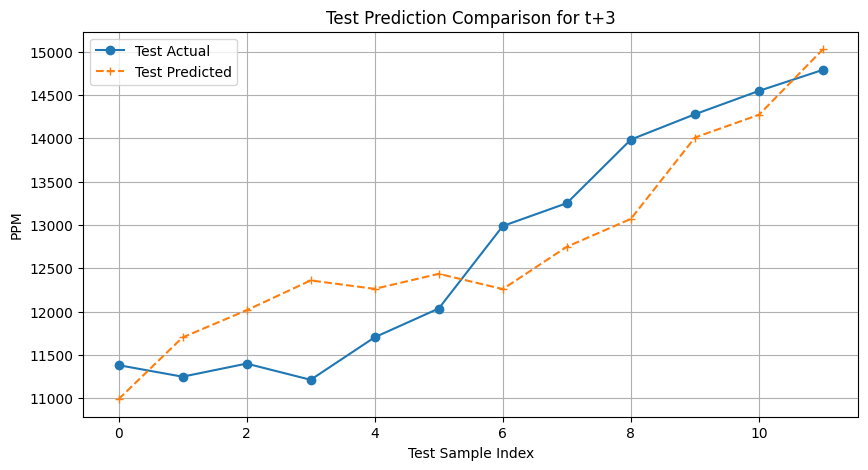

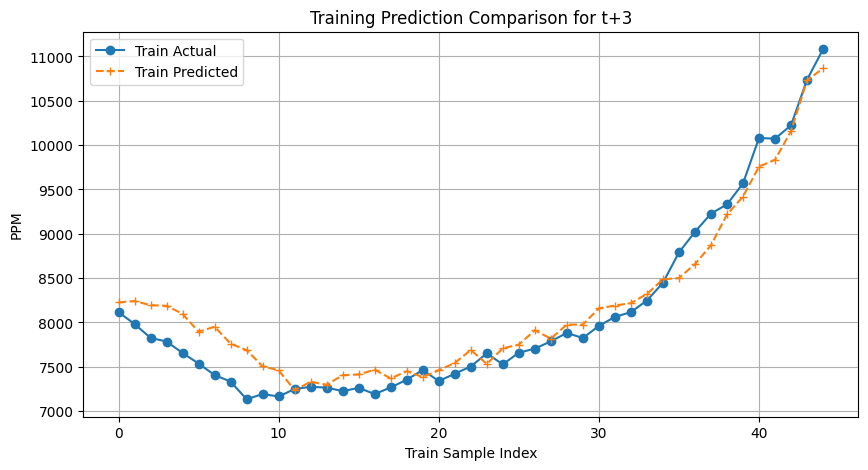

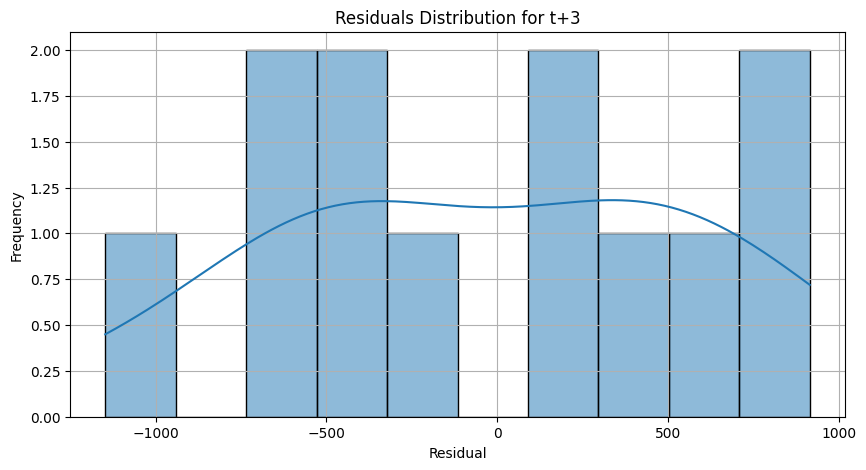

<Figure size 1000x500 with 0 Axes>

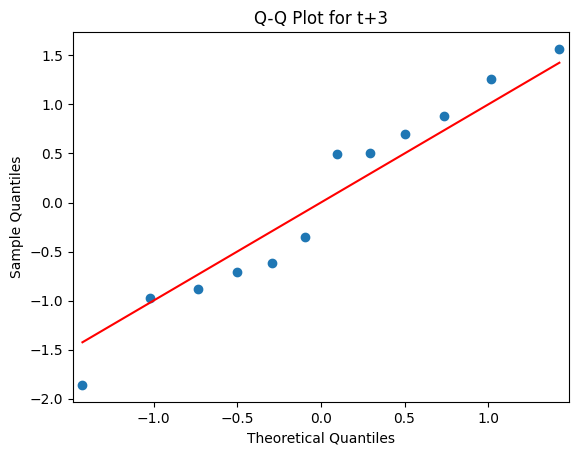

Training time for horizon t+4: 0.0000 seconds
Horizon t+4:
 - Input shape: (56, 5) (features per sample: 5)
 - Train size: 44, Test size: 12
Train Metrics (Original Scale): MSE: 93002.3425, MAE: 254.9060, MAPE: 3.21%, R²: 0.9140
Test Metrics  (Original Scale): MSE: 520638.0371, MAE: 641.5186, MAPE: 5.01%, R²: 0.7091
Statistical tests for Horizon t+4 (Test Data, Original Scale):
 - Shapiro–Wilk: stat = 0.9321, p-value = 0.4027
 - Durbin–Watson: 0.3619
 - Breusch–Pagan: LM stat = 4.4916, p-value = 0.4810

Variance Inflation Factor (VIF):
  Feature         VIF
0      X0    6.655458
1      X1  120.441429
2      X2  279.122927
3      X3  326.763732
4      X4  175.310741

Ramsey RESET Test:
 - F-statistic: 0.0095
 - p-value: 0.9230
 - df_diff: 1.0, df_resid: 37.0


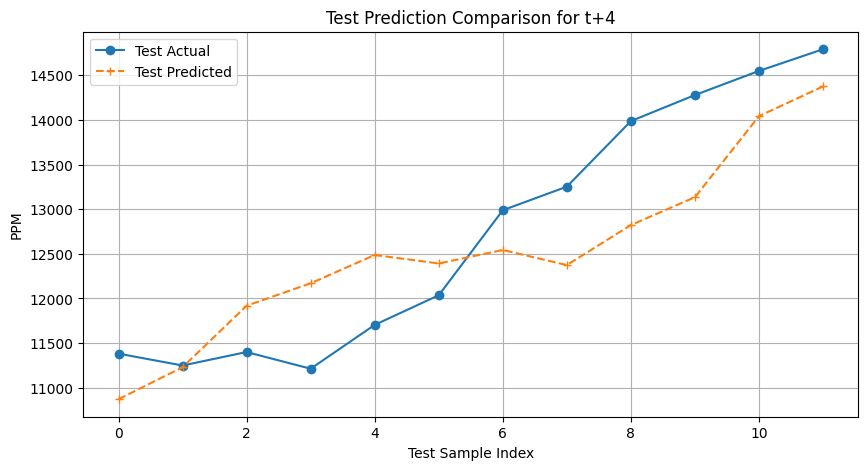

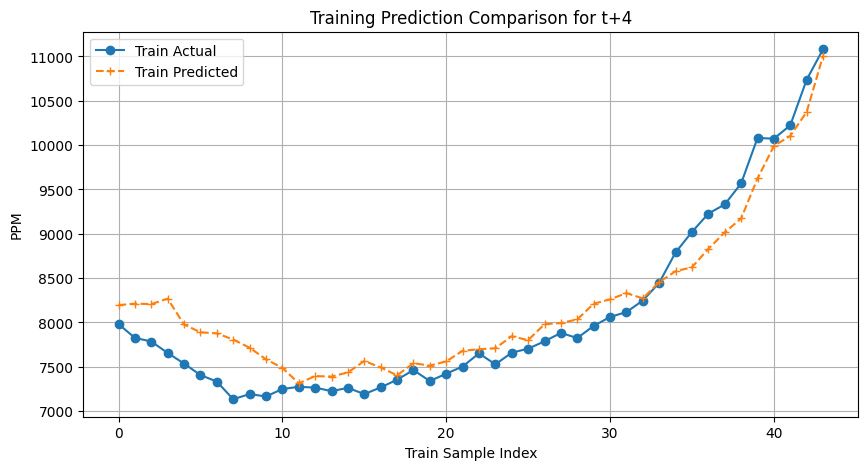

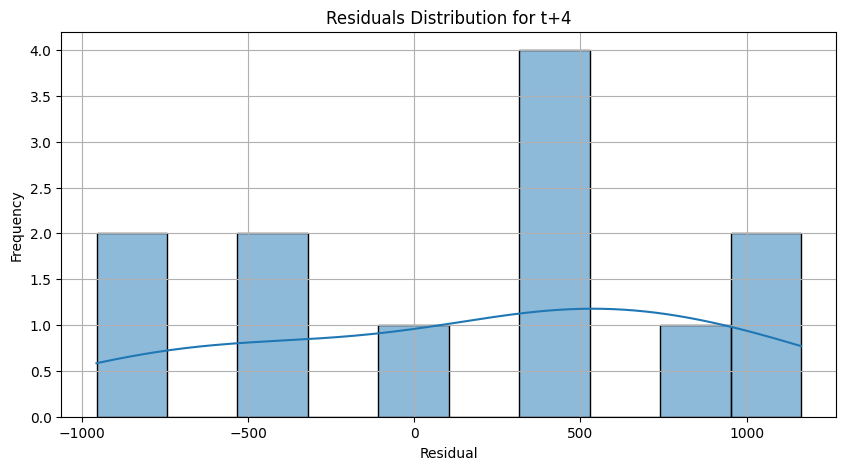

<Figure size 1000x500 with 0 Axes>

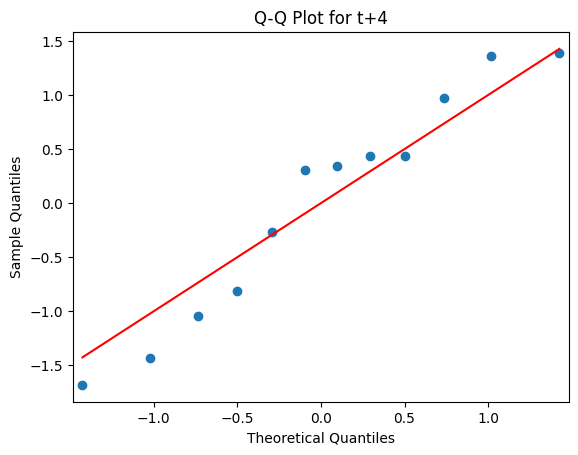


Training Predictions vs Actual DataFrame (Original Scale, No Constant):
   Sample  t+1 Actual  t+1 Predicted  t+2 Actual  t+2 Predicted  t+3 Actual  \
0       0      8207.0    8207.913934      8151.0    8216.683831      8117.0   
1       1      8151.0    8232.021711      8117.0    8240.984683      7982.0   
2       2      8117.0    8176.344472      7982.0    8189.735773      7826.0   
3       3      7982.0    8145.763314      7826.0    8166.126769      7785.0   
4       4      7826.0    8014.530098      7785.0    8047.126131      7656.0   

   t+3 Predicted  t+4 Actual  t+4 Predicted  
0    8226.091052      7982.0    8195.531952  
1    8241.351847      7826.0    8211.759062  
2    8194.737077      7785.0    8207.013219  
3    8188.302617      7656.0    8267.978234  
4    8096.694004      7536.0    7977.164092  

Test Predictions vs Actual DataFrame (Original Scale, No Constant):
   Sample  t+1 Actual  t+1 Predicted  t+2 Actual  t+2 Predicted  t+3 Actual  \
0       0     11382.0   1140

In [3]:
def inverse_transform_y(y_scaled, scaler):
    y_scaled = np.array(y_scaled).reshape(-1, 1)
    dummy = np.zeros((len(y_scaled), 2))
    dummy[:, 0] = y_scaled.flatten()
    return scaler.inverse_transform(dummy)[:, 0]


features = df[["cena_za_m", "Funkcja_stand_min_max"]].values  # shape: (n_samples, 2)

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

lookback = 1
forecast_horizon = 4   # forecasting t+1, t+2, t+3, t+4
split_ratio = 0.8      

# Dictionaries to store datasets, models, metrics, training times and model parameters
X_datasets = {}
y_datasets = {}
models = {}
train_data = {}
test_data = {}
metrics_train = {}
metrics_test = {}
training_times = {}
model_parameters = {}

n_samples = len(features_scaled)

overall_start_time = time.time()

for h in range(1, forecast_horizon + 1):
    X_h = []
    y_h = []
    for i in range(n_samples - lookback - h + 1):
        seq_cena = features_scaled[i : i + lookback, 0]  # shape: (lookback,)
        future_funkcja = features_scaled[i + lookback : i + lookback + h, 1]  # shape: (h,)
        # Combined input sequence for the model
        X_sample = np.concatenate([seq_cena, future_funkcja])
        # Target: the "cena_za_m" value at time t+h
        y_value = features_scaled[i + lookback + h - 1, 0]
        X_h.append(X_sample)
        y_h.append(y_value)
    
    X_h = np.array(X_h)
    y_h = np.array(y_h)
    X_datasets[h] = X_h
    y_datasets[h] = y_h

    # Train-test split for the current horizon
    n_h = len(X_h)
    split_index = int(split_ratio * n_h)
    X_train = X_h[:split_index]
    y_train = y_h[:split_index]
    X_test = X_h[split_index:]
    y_test = y_h[split_index:]
    train_data[h] = (X_train, y_train)
    test_data[h] = (X_test, y_test)
    
    # Fitting a Linear Regression model 
    start_time = time.time()
    model = LinearRegression(fit_intercept=False)
    model.fit(X_train, y_train)
    end_time = time.time()
    training_times[h] = end_time - start_time
    models[h] = model
    

    model_parameters[h] = model.coef_
    
    print(f"Training time for horizon t+{h}: {training_times[h]:.4f} seconds")
    print(f"Horizon t+{h}:")
    print(f" - Input shape: {X_h.shape} (features per sample: {X_h.shape[1]})")
    print(f" - Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Inverse-transform predictions and actuals
    y_train_inv = inverse_transform_y(y_train, scaler)
    y_pred_train_inv = inverse_transform_y(y_pred_train, scaler)
    y_test_inv = inverse_transform_y(y_test, scaler)
    y_pred_test_inv = inverse_transform_y(y_pred_test, scaler)
    
    # Metrics
    mse_train = mean_squared_error(y_train_inv, y_pred_train_inv)
    mae_train = mean_absolute_error(y_train_inv, y_pred_train_inv)
    mape_train = mean_absolute_percentage_error(y_train_inv, y_pred_train_inv) * 100
    r2_train = r2_score(y_train_inv, y_pred_train_inv)
    
    mse_test = mean_squared_error(y_test_inv, y_pred_test_inv)
    mae_test = mean_absolute_error(y_test_inv, y_pred_test_inv)
    mape_test = mean_absolute_percentage_error(y_test_inv, y_pred_test_inv) * 100
    r2_test = r2_score(y_test_inv, y_pred_test_inv)
    
    metrics_train[h] = (mse_train, mae_train, mape_train, r2_train)
    metrics_test[h] = (mse_test, mae_test, mape_test, r2_test)
    
    print(f"Train Metrics (Original Scale): MSE: {mse_train:.4f}, MAE: {mae_train:.4f}, MAPE: {mape_train:.2f}%, R²: {r2_train:.4f}")
    print(f"Test Metrics  (Original Scale): MSE: {mse_test:.4f}, MAE: {mae_test:.4f}, MAPE: {mape_test:.2f}%, R²: {r2_test:.4f}")
    
    # Statistical Tests on Test Residuals 
    residuals_test_inv = y_test_inv - y_pred_test_inv
    shapiro_stat, shapiro_p = shapiro(residuals_test_inv)
    dw_stat = sm.stats.stattools.durbin_watson(residuals_test_inv)
    X_test_const = sm.add_constant(X_test, has_constant='add')
    bp_stat, bp_p, _, _ = het_breuschpagan(residuals_test_inv, X_test_const)
    
    print(f"Statistical tests for Horizon t+{h} (Test Data, Original Scale):")
    print(f" - Shapiro–Wilk: stat = {shapiro_stat:.4f}, p-value = {shapiro_p:.4f}")
    print(f" - Durbin–Watson: {dw_stat:.4f}")
    print(f" - Breusch–Pagan: LM stat = {bp_stat:.4f}, p-value = {bp_p:.4f}")
    
    vif_values = []
    for i in range(X_train.shape[1]):
        vif = variance_inflation_factor(X_train, i)
        vif_values.append(vif)
    
    vif_df = pd.DataFrame({
        "Feature": [f"X{i}" for i in range(X_train.shape[1])],
        "VIF": vif_values
    })
    print("\nVariance Inflation Factor (VIF):")
    print(vif_df)
    
    X_train_sm = sm.add_constant(X_train)
    ols_model = sm.OLS(y_train, X_train_sm).fit()
    reset_test = sm.stats.diagnostic.linear_reset(ols_model, power=2, test_type='fitted', use_f=True)
    f_stat = reset_test.fvalue
    reset_p = reset_test.pvalue
    df_diff = reset_test.df_num
    df_resid = reset_test.df_denom
    print(f"\nRamsey RESET Test:")
    print(f" - F-statistic: {f_stat:.4f}")
    print(f" - p-value: {reset_p:.4f}")
    print(f" - df_diff: {df_diff}, df_resid: {df_resid}")

    plt.figure(figsize=(10, 5))
    plt.plot(y_test_inv, label="Test Actual", marker="o")
    plt.plot(y_pred_test_inv, label="Test Predicted", marker="+", linestyle="--")
    plt.title(f"Test Prediction Comparison for t+{h}")
    plt.xlabel("Test Sample Index")
    plt.ylabel("PPM")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.plot(y_train_inv, label="Train Actual", marker="o")
    plt.plot(y_pred_train_inv, label="Train Predicted", marker="+", linestyle="--")
    plt.title(f"Training Prediction Comparison for t+{h}")
    plt.xlabel("Train Sample Index")
    plt.ylabel("PPM")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(10, 5))
    sns.histplot(residuals_test_inv, bins=10, kde=True)
    plt.title(f"Residuals Distribution for t+{h}")
    plt.xlabel("Residual")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(10, 5))
    sm.qqplot(residuals_test_inv, line="s", fit=True)
    plt.title(f"Q-Q Plot for t+{h}")
    plt.show()

overall_end_time = time.time()
overall_execution_time = overall_end_time - overall_start_time

min_train_length = min([len(train_data[h][1]) for h in range(1, forecast_horizon + 1)])
min_test_length = min([len(test_data[h][1]) for h in range(1, forecast_horizon + 1)])

df_predictions_train = pd.DataFrame({"Sample": np.arange(min_train_length)})
df_predictions_test = pd.DataFrame({"Sample": np.arange(min_test_length)})

for h in range(1, forecast_horizon + 1):
    X_train, y_train = train_data[h]
    X_test, y_test = test_data[h]
    model = models[h]
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Inverse-transform
    y_train_inv = inverse_transform_y(y_train, scaler)
    y_pred_train_inv = inverse_transform_y(y_pred_train, scaler)
    y_test_inv = inverse_transform_y(y_test, scaler)
    y_pred_test_inv = inverse_transform_y(y_pred_test, scaler)
    
    df_predictions_train[f"t+{h} Actual"] = y_train_inv[:min_train_length]
    df_predictions_train[f"t+{h} Predicted"] = y_pred_train_inv[:min_train_length]
    
    df_predictions_test[f"t+{h} Actual"] = y_test_inv[:min_test_length]
    df_predictions_test[f"t+{h} Predicted"] = y_pred_test_inv[:min_test_length]

print("\nTraining Predictions vs Actual DataFrame (Original Scale, No Constant):")
print(df_predictions_train.head())

print("\nTest Predictions vs Actual DataFrame (Original Scale, No Constant):")
print(df_predictions_test.head())

# Saving to excel for attention model
df_predictions_train.to_excel("training_predictions_no_constant.xlsx", index=False)
df_predictions_test.to_excel("test_predictions_no_constant.xlsx", index=False)

last_seq_cena = features_scaled[-lookback:, 0]  # shape: (lookback,)
future_predictions = {}
for h in range(1, forecast_horizon + 1):
    future_funkcja = features_scaled[-h:, 1]
    X_future = np.concatenate([last_seq_cena, future_funkcja]).reshape(1, -1)
    pred = models[h].predict(X_future)
    pred_inv = inverse_transform_y(pred, scaler)[0]
    future_predictions[f"t+{h}"] = pred_inv
    print(f"Future prediction for t+{h} (Original Scale, No Constant): {pred_inv}")

steps = np.arange(1, forecast_horizon + 1)
preds = [future_predictions[f"t+{h}"] for h in range(1, forecast_horizon + 1)]
df_future_predictions = pd.DataFrame({
    "Step": steps,
    "Predicted": preds
})
print("\nFuture Predictions for Next Year (Original Scale, No Constant):")
print(df_future_predictions)

print("\nModel Parameters and Training Times:")
for h in range(1, forecast_horizon + 1):
    print(f"\nHorizon t+{h}:")
    print("  Training time: {:.4f} seconds".format(training_times[h]))
    print("  Coefficients: ", model_parameters[h])
    
print("\nTotal execution time: {:.4f} seconds".format(overall_execution_time))


## Multi-step future predictions using the previously trained linear regression model.

In [4]:
linear_model_no_const = models[forecast_horizon]

last_seq_cena = features_scaled[-lookback:, 0]  # shape: (lookback,)

# This list will store the multi-step forecasts (in scaled units)
future_predictions_scaled = []

# Future time indices for the polynomial trend for "Funkcja_stand_min_max"
future_time_steps = np.arange(len(df), len(df) + forecast_horizon).reshape(-1, 1)
# Predict the polynomial trend values for each future time step
future_funkcja_poly = model_best.predict(best_poly.transform(future_time_steps))

# Initial input vector for forecasting
current_input = np.concatenate([last_seq_cena, np.zeros(forecast_horizon)])

for step in range(forecast_horizon):
    current_input[lookback + step] = future_funkcja_poly[step]
    
    X_future_sample = current_input.reshape(1, -1)
    
    next_cena_scaled = linear_model_no_const.predict(X_future_sample).flatten()
    
    future_predictions_scaled.append(next_cena_scaled)
    
    current_input = np.roll(current_input, -1)
    current_input[-1] = next_cena_scaled[0]

future_predictions_scaled = np.array(future_predictions_scaled)
future_predictions = inverse_transform_y(future_predictions_scaled, scaler)
future_predictions = future_predictions.flatten()
future_predictions = future_predictions[:forecast_horizon]

# Df for future predictions
df_future_predictions = pd.DataFrame({
    "Step": np.arange(1, forecast_horizon + 1),
    "Predicted": future_predictions
})

print("\nFuture Predictions for Next Year (Original Scale, No Constant):")
print(df_future_predictions)



Future Predictions for Next Year (Original Scale, No Constant):
   Step     Predicted
0     1  15827.407064
1     2  15665.066198
2     3   9240.032713
3     4  16305.411046
